In [19]:
import collections
import functools
from random import randint, random
from itertools import product

import numpy as np
import pandas as pd
from scipy.spatial import SphericalVoronoi, geometric_slerp, Delaunay, ConvexHull
from scipy.special import sph_harm

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.tri as mpl_tri
from matplotlib import pyplot, cm
from matplotlib.colors import to_rgba
from mpl_toolkits.mplot3d import Axes3D, proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns

from IPython.display import Math, HTML

import shapely
from shapely import GeometryCollection, LineString, Point
from shapely.geometry import MultiPoint, Polygon as sPolygon
from shapely.ops import split
import shapely.plotting
import geopandas as gpd

import stripy as stripy
import cartopy
import cartopy.crs as ccrs
import networkx as nx
from ordered_set import OrderedSet
import PyNormaliz as pyn

from mayavi import mlab

import vtk
import vtkmodules.vtkInteractionStyle
import vtkmodules.vtkRenderingOpenGL2
from vtkmodules.vtkCommonColor import vtkNamedColors
from vtkmodules.vtkFiltersSources import vtkCylinderSource
from vtkmodules.vtkRenderingCore import (
    vtkActor,
    vtkPolyDataMapper,
    vtkRenderWindow,
    vtkRenderWindowInteractor,
    vtkRenderer
)

import pyvista as pv

from sage.modules.lattices_common import *
from sage.plot.arc import Arc, arc

load("/home/dzack/gitclones/lines-of-symmetry/symmetry.py")

def generate_random_integer(max_value=10):    
    if random() < 0.25:
        return 0
    else:
        return ZZ.random_element(1, max_value + 1)
def refl(m):
    return 1/(1+m^2) * Matrix(ZZ, 2, [1-m^2, 2*m, 2*m, m^2-1])

def ref_pt_by_points(p, q1, q2):
    m12 = (q2[1] - q1[1]) / (q2[0] - q1[0])
    b12 = q2[1] - m12 * q2[0]
    return ref_pt(p, m12, b12)
    
def ref_pt(p, m, b):
    M_mb = line_ref(m, b)
    p_aff = vector(ZZ, 3, [p[0], p[1], 1])
    p_ref = M_mb * p_aff
    return vector(ZZ, 2, [p_ref[0], p_ref[1]])

def check_sym_commute(m1, b1, m2, b2):
    Ml1 = line_ref(m1, b1)
    Ml2 = line_ref(m2, b2)
    return Ml1 * Ml2 - Ml2 * Ml1 == zero_matrix(ZZ, 3)

def line_ref(m, b):
    return 1/(1+m^2) * Matrix(ZZ, 3, [1-m^2, 2*m, -2*m*b, 2*m, m^2-1, 2*b, 0, 0, 1+m^2])

def lat_len(p, q):
    return (vector(p) - vector(q)).norm() * sqrt(2)/2

def pp(X):
    return LatexExpr((str(latex(X).replace("0", "\\cdot"))))

def rot_mat(theta):
    return matrix(QQbar, 2, [cos(theta), -sin(theta), sin(theta), cos(theta)])

def blowup(X, i):
    v1, v2 = X.fan().cones()[2][i]
    return X.resolve(new_rays=[v1 + v2])

def intersection_number(X, i):
    r0 = X.fan().cones()[1][i]
    x0 = r0.semigroup_generators()[0]
    containing_cones = [l for l in X.fan().cones()[2] if r0.is_face_of(l)]
    v1, v2 = containing_cones[0]
    w1, w2 = containing_cones[1]
    y1, y2 = [x for x in [v1, v2, w1, w2] if x != x0]
    for i in range(100):
        if y1 + y2 == i * x0:
            return(-i)
    raise ValueError("Issue computing intersection number.")

def intersection_numbers(X):
    return dict(lmap(
        lambda x: (x[0], intersection_number(X, x[0])), 
    ))

e1 = vector((1, 0))
e2 = vector((0, 1))
e1.set_immutable()
e2.set_immutable()
std_basis = OrderedSet([e1, e2])

In [20]:
def sort_points(v1, v2):
    if v1[0] < v2[0]:
        return [v1, v2]
    elif v2[0] < v1[0]:
        return [v2, v1]
    elif v1[0] == v2[0]:
        if v1[1] < v2[1]:
            return [v1, v2]
        elif v2[1] < v1[1]:
            return [v2, v1]
        else:
            return [v1, v2]
            
class LineSegment():

    def __init__(self, start, end, is_unbounded=True, label=None):
        start, end == sort_points(start, end)
        self.start = vector( start )
        self.end = vector( end )
        self.line = LineString( [self.start, self.end] )
        self.centroid = vector( lmap(lambda x: x[0], list( self.line.centroid.xy )) )
        self.is_unbounded = is_unbounded
        self.label = label
        self.direction_vector = self.end - self.start
        self.orthogonal_vector = matrix(2, [0,-1, 1, 0]) * self.direction_vector

    def xs_2d(self):
        return [ self.start[0], self.end[0] ]
    def ys_2d(self):
        return [ self.start[1], self.end[1] ]
    def xs_3d(self):
        return self.xs_2d() + [0]
    def ys_3d(self):
        return self.ys_2d() + [0]

    def plot_2d_strict(self, color="black", lw=1, fontsize=4, withlabels=False, alpha=0.5):
        # ax.plot(
        #     self.xs_2d(),
        #     self.ys_2d(),
        #     color = color,
        #     lw = lw
        # )
        ax.quiver(
            [ self.start[0] ],
            [ self.start[1] ],
            [ self.direction_vector[0] ],
            [ self.direction_vector[1] ],
            color=color, angles='xy', scale_units='xy', scale=1, alpha=alpha, lw=lw
        )
        if self.label is not None and withlabels:
            if self.is_unbounded:
                loc = self.direction_vector.normalized() + self.start + self.orthogonal_vector.normalized()/3
                color = "red"
            else:
                loc = self.start + (self.direction_vector/2) + self.orthogonal_vector.normalized()/10
                color = "black"
            t = ax.text(
                loc[0],
                loc[1],
                self.label,
                fontsize = fontsize,
                color = color,
                alpha = 1
            )
            t.set_bbox(dict(facecolor='gray', alpha=0.8, edgecolor='black'))
        return

    def plot_2d_in_3d(self):
        pass

    def plot(self):
        return self.line

    def integral_points(self):
        P = Polyhedron( [self.start, self.end] )
        return lmap(lambda x: vector(x), P.integral_points())

    def move(self, new_start, new_end):
        self.start = vector( new_start )
        self.end = vector( new_end )
        self.line = LineString( [self.start, self.end] )
        self.centroid = vector( lmap(lambda x: x[0], list( ls.centroid.xy )) )

    def length(self):
        pass
        
    def contains(self, other):
        return self.line.contains( other )

    def intersects(self, other):
        return self.line.intersects( other )

    def intersection(self, other):
        return self.line.intersection( other )

    def union(self, other):
        return self.line.union( other )

    def difference(self, other):
        return self.line.difference( other )

    def complement(self, other):
        return self.difference( other )

    def bounding_box(self):
        x1, y1, x2, y2 = self.line.bounds
        return( [
            vector(x1, y1),
            vector(x2, y1),
            vector(x1, y2),
            vector(x2, y2)
        ])

class PolygonalCell():

    def __repr__(self):
        return(f"{self.num_edges()}-sided polygon {self.label} with {len(self.vertices)} vertices.")

    def __init__(self, list_vertices, label):
        self.label = label
        self.original_vertices = list_vertices
        self.hull = ConvexHull(list_vertices)
        self.vertices = self.hull.points[ self.hull.vertices ]
        self.polygon = sPolygon( self.vertices )
        self.polyhedron = Polyhedron( self.vertices )

    def integral_points(self):
        return lmap(lambda x: vector(x), self.polyhedron.integral_points())

    def plot_2d_strict(self, **kwargs):
        # ax.add_patch(plt.Polygon(
        #         np.array( p.exterior.xy ).T, 
        #         alpha=0.4, color="green", ec="black", lw=5
        #     ))
        shapely.plotting.plot_polygon(self.polygon, add_points=False, **kwargs)
        return

    def num_edges(self):
        return len( [x for x in self.polyhedron.bounded_edges() ] )

    def bounding_box(self):
        return self.polyhedron.bounding_box()
        
    def centroid(self):
        return self.polyhedron.centroid()

    def polar(self):
        return self.polyhedron.polar()

    def hyperplanes(self):
        # return self.polyhedron.Hrepresentation()
        return self.polyhedron.hyperplane_arrangement()

    def pyramid(self):
        return self.polyhedron.pyramid()

    def contains(self, other):
        return self.polyhedron.contains( other )

    def f_vector(self):
        return self.polyhedron.f_vector()

In [104]:
Z = IntegralLattice( Matrix(ZZ, [1] ) )
Z2 = Z.twist(2)

H = IntegralLattice("H")
U = H

H_2 = H.twist(2)
U_2 = H_2

E8 = IntegralLattice("E8").twist(-1)

E8_2 = E8.twist(2)

L_18_2_0 = U_2 @ E8**2 # 19-dim
L_18_0_0 = U @ E8**2 # 22-dim

Ten = U.direct_sum(U.twist(2)).direct_sum(E8.twist(2))
Tco = Z2.direct_sum(U.twist(2)).direct_sum(E8.twist(2))
TdP = U.direct_sum(U_2).direct_sum(E8).direct_sum(E8)

def divisibility(v, L):
    dot_L = lambda x,y : x * L.gram_matrix() * y
    nm_L = lambda x: dot_L(x, x)
    dots = [ abs( dot_L(v, x) ) for x in L.gens() ]
    #print(dots)
    nonzero_dots = [abs(l) for l in dots if l != 0]
    return ( min(nonzero_dots), dots)

def e(i, n):
    v = vector( [0] * n )
    v[i] = 1
    return v

def vector_subs(expr, subs_dict):
    """Substitute vectors for symbolic variables in an expression"""
    # Get all variables in the expression
    vars_in_expr = expr.variables()
    
    # Start with zero vector of appropriate dimension
    if not subs_dict:
        return expr
    
    # Get dimension from first vector in substitution
    dim = len(list(subs_dict.values())[0])
    result = vector([0] * dim)
    
    # Extract coefficients and constant term
    expanded = expr.expand()
    
    # Handle each term manually
    for var in vars_in_expr:
        coeff = expanded.coefficient(var)
        if var in subs_dict:
            result += coeff * subs_dict[var]
    
    # Add constant term
    constant = expanded.subs({var: 0 for var in vars_in_expr})
    result += constant * vector([1] * dim)
    
    return result

# Sort by (nonzero_count, -lexicographic order)
def sort_basis(v, w):
    def cmp_v_w(v,w):
        num_v = sum([ abs(lv[i]) * 10^(i) for i in range(len(lv)) ])
        num_w = sum([ abs(lw[i]) * 10^(i) for i in range(len(lw)) ])
        if v < w:
            return 1
        else:
            return -1
    lv = list(v)
    lw = list(w)
    nv = len([ i for i,_ in enumerate(v) if v[i]!=0])
    nw = len([ i for i,_ in enumerate(w) if w[i]!=0])
    if abs(nv - nw) > 3:
        if nv < nw:
            return -1
        else:
            return 1
    else:
        first_i_v = min( [i for i, _ in enumerate(v) if v[i]!=0] )
        first_i_w = min( [i for i, _ in enumerate(w) if w[i]!=0] )
        if first_i_v < first_i_w:
            return -1
        else:
            return 1

# Roots

In [98]:
e,f ,ep,fp, a1,a2,a3,a4,a5,a6,a7,a8, a1t,a2t,a3t,a4t,a5t,a6t,a7t,a8t = L_20_2_0.gens()
eb,fb, epb,fpb, wb1,wb2,wb3,wb4,wb5,wb6,wb7,wb8, w1t,w2t,w3t,w4t,w5t,w6t,w7t,w8t = ((L_20_2_0.gram_matrix()).inverse()).columns()

v1 = a8t
v2 = ep + fp + wb1 + w8t
v3 = a1 
v4 = a3
v5 = a4
v6 = a5
v7 = a6
v8 = a7
v9 = a8
v10 = ep + fp + wb8 + w1t
v11 = a1t
v12 = a3t
v13 = a4t
v14 = a5t
v15 = a6t
v16 = a7t

v17 = ep + w8t
v18 = a2
v19 = ep + wb8
v20 = a2t

v21 = fp - ep
v22 = 5 ep + 3 fp + 2 wb2 + 2 w2t

V = [v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22]

for v in V:
    v.set_immutable()

assert len(list(set(V))) == 22

w0 = v13
w1 = v12
w2 = v11
w3 = v10
w4 = v9
w5 = v8
w6 = v7
w7 = v6
w8 = v5
w9 = v4
w10 = v3
w11 = v2
w12 = v1
w13 = v16
w14 = v15
w15 = v14

w16 = v20
w17 = v19
w18 = v18
w19 = v17

w20 = v22
w21 = v21

G_18_2_0 = L_20_2_0.sub_gram_matrix([
    v1, v2, v3, v4, v5, v6, v7, v8, 
    v9, v10, v11, v12, v13, v14, v15, v16, 
    v17, v18, v19, v20, v21, v22
])



W = [w0,w1,w2,w3,
     w4,w5,w6,w7,
     w8,w9,w10,w11,
     w12,w13,w14,w15,
     w16,w17,w18,w19,
     w20,w21
    ]

for w in W:
    w.set_immutable()

# r1, r2, r3, r4 = L_20_2_0.ambient_module().base_extend(QQ).linear_dependence([
#     v1, v2, v3, v4, v5, v6, v7, v8, 
#     v9, v10, v11, v12, v13, v14, v15, v16, 
#     v17, v18, 
#     v19, v20, 
#     v21, v22
# ], zeros="right")

# show(
#     table([ [f"$v_{{{i+1}}}$" for i in range(22)], list(r1), list(r2), list(r3), list(r4) ])
# )

assert len(list(set(W))) == 22

# IAS Classes

In [24]:
class IAS_Holder:

    def __init__(self, 
                 soln_projection_matrix, 
                 ell_to_vector_projection,
                 direction_vectors,
                 surgery_vectors,
                 surgery_vec_indices,
                 IAS_name,
                 ell_vector
        ):
        self.soln_projection_matrix = soln_projection_matrix
        self.ell_to_vector_projection = ell_to_vector_projection
        self.direction_vectors = direction_vectors
        self.surgery_vectors = surgery_vectors
        self.surgery_vec_indices = surgery_vec_indices
        self.IAS_name = IAS_name
        self.ell_vector = ell_vector

        S.<a0, ..., a9> = PolynomialRing(QQ, 10)

        self.a_vector = vector(SR, [a0, a1, a2, a3, a4, a5, a6, a7, a8, a9] )

        self.surgery_triangles = {}

    def get_surgery_triangle(self, base_l, apex, base_r):
        g = Graphics()
        g += arrow( base_l, apex, color="red", linestyle="dotted")
        g += arrow( apex, base_r,  color="red", linestyle="dotted")
        P = Polyhedron([ base_l, apex, base_r ])
        g += P.plot(color="red", alpha=0.3)
    
        base = (vector(base_l) - vector(base_r)).norm() * sqrt(2)/2
        height = (2 * P.volume() / base) 
        # print(f"Surgery of height {height}, vector length {gcd(apex - base_l)}")
        return g

    def ell_solution(self, ell):
        self.full_ell_vector = ell
        self.dir_vector_coefficients = self.ell_to_vector_projection * self.full_ell_vector
        
        self.soln_plot_vecs = {}
        if self.IAS_name == "18_2_0":
            for i, (label, v) in enumerate(self.direction_vectors.items()):
                w = vector(SR, (self.dir_vector_coefficients)[i] * v)
                self.soln_plot_vecs[label] =  w
            self.soln_surgery_vecs = {
                "v16": self.surgery_vectors["v_16"] * self.dir_vector_coefficients[16],
                "v17": self.surgery_vectors["v_17"] * self.dir_vector_coefficients[17],
                "v18": self.surgery_vectors["v_18"] * self.dir_vector_coefficients[18],
                "v19": self.surgery_vectors["v_19"] * self.dir_vector_coefficients[19],
            }
        elif self.IAS_name == "18_0_0":
            for i, (label, v) in enumerate(self.direction_vectors.items()):
                w = vector(SR, (self.dir_vector_coefficients)[i+1] * v)
                self.soln_plot_vecs[label] =  w
            self.soln_surgery_vecs = {
                "v1": self.surgery_vectors["v_1"] * self.dir_vector_coefficients[0],
                "v19": self.surgery_vectors["v_19"] * self.dir_vector_coefficients[18],
            }
        
        return(self.full_ell_vector, self.soln_plot_vecs, self.soln_surgery_vecs)

    def a_to_ell(self, a):
        assert len(a) == 10, "Expected 10 parameters"
        return self.soln_projection_matrix * a

    def plot_random_IAS(self, max_a=3, surg_inflate=2):
        a = vector([ generate_random_integer(max_a) for _ in range(10)])
        if self.IAS_name == "18_2_0":
            if a[8] == 0: 
                a[8] = 1
            if a[9] == 0: 
                a[9] = 1
            a[8] = surg_inflate * a[8]
            a[9] = surg_inflate * a[9]
        elif self.IAS_name == "18_0_0":
            if a[0] == 0:
                a[0] = 1
            a[0] = surg_inflate * a[0]
            
        return self.plot_IAS_a(a)

    def get_polygon_points(self):
        initial_pos = vector([0, 0])
        current_pos = initial_pos
        polygon_points = {
            "p_{0}": initial_pos
        }
        
        for i, (label, vi) in enumerate( self.soln_plot_vecs.items() ):
            #if self.IAS_name == "18_2_0" and i == 15: continue
            new_pos = current_pos + vi
            polygon_points[f"p_{{{i+1}}}"] = new_pos
            current_pos = new_pos
        
        return polygon_points

    def plot_IAS_a(self, a):
        assert len(a) == 10, "Expected 10 parameters"
        a = vector(ZZ, a)
        ell = self.a_to_ell(a)
        g = self.plot_IAS_ell( ell )
        display( table([
            list(self.a_vector),
            list(a)
        ]) )
        return g

    def plot_IAS_ell(self, ell, surg_starts = None):
        #assert len(ell) == 20, "Expected 10 parameters"
        ell = vector(ZZ, ell)
        _,_,_ = self.ell_solution(ell)
        
        display( table([
            list(self.ell_vector), 
            list(self.full_ell_vector)
        ]) )
    
        self.poly_pts = self.get_polygon_points()
        self.P = Polyhedron( 
            lmap(lambda x: vector(ZZ, x), self.poly_pts.values() ) 
        )
        self.P_at_origin = Polyhedron( 
            lmap(lambda x: vector(ZZ, x) - vector( self.P.centroid() ), self.poly_pts.values() ) 
        )
        self.AutGroup = self.P_at_origin.restricted_automorphism_group(output="matrix")
        print(f"Aut(P) = {self.AutGroup.structure_description()}, order { self.AutGroup.order() } with {self.AutGroup.ngens()} generators:")
        for m in lmap(lambda m: ( matrix(m)[0:2,0:2] ), self.AutGroup.gens() ):
            show(m)
        
        g = self.__plot_IAS__(surg_starts)
        
        for m in self.AutGroup:
            M0 = matrix(m)[0:2, 0:2]
            if M0 == matrix(2, [1,0,0,1]): continue
            for e, vs, m in M0.eigenvectors_right():
                if e == -1 and m == 2:
                    if set(vs) == std_basis:
                        g += arc(vector((0,0)) + self.P.centroid(), 2, sector=(2pi/20,2pi-2pi/20), color="green", linestyle="--", thickness=3)
                if e == 1:
                    v = vector(QQbar, vs[0]).normalized()
                    n = ceil( self.P.radius() )
                    g += line( [ self.P.centroid()-n*v, self.P.centroid()+n*v ], linestyle="--", color="green", thickness=3)
            
        return g

    def __plot_IAS__(self, surg_starts = None):   
        g = Graphics()
        pts = list(self.poly_pts.values())
        for i in range(len(pts)-1):
            pt1 = pts[i]
            pt2 = pts[i+1]
            if pt1 == pt2:
                continue
            g += arrow2d(pt1, pt2)
            #g += point(pt1, size=80, color="blue")
            center_to_pt1 = pt1 - vector( self.P.centroid() )
            g += text(f'{pt1}', pt1 + (1/4)*center_to_pt1 )
        g += text(f'{pts[ len(pts)-1 ] }', pts[ len(pts)-1 ] + vector((-1,0)))
    
        g += polygon( pts , alpha=0.25)
    
        for p in self.P.integral_points():
            g += point( p, color="blue", size=50, alpha=0.5)
    
        s_vecs = lmap(lambda v: vector(ZZ, v), self.soln_surgery_vecs.values() )
        
        self.surg_pts = {}
        for i, index in enumerate(self.surgery_vec_indices):
            si = s_vecs[i]
            surg_size = gcd(si) 
                
            p_i = vector(ZZ, self.poly_pts[f"p_{{{index}}}"])
            p_i1 = vector(ZZ, self.poly_pts[f"p_{{{index + 1}}}"])
            j = 2
            while p_i == p_i1:
                p_i1 = vector(ZZ, self.poly_pts[f"p_{{{index+j}}}"])
                j += 1
                    
            v_i = p_i1 - p_i
            edge_len = gcd(v_i)
            v_i_prim = v_i / edge_len
            for m in range(edge_len + 1):
                g += point( p_i + (m*v_i_prim), color="green",size=100)
            g += line( [p_i, p_i1], color="green", thickness=4)

            self.place_surgery_triangle(
                i,
                surg_size,
                p_i,
                p_i1,
                si
            )

        for _, (i, tri) in enumerate( self.surgery_triangles.items() ):
            si = s_vecs[i]
            surg_size = gcd(si)
            if surg_size == 0: 
                continue
            base_l, apex, base_r = tri
            P_triangle = Polyhedron([ base_l, apex, base_r ])
            g += self.get_surgery_triangle(base_l, apex, base_r)
            
            for p in P_triangle.integral_points():
                g += point( p, color="red", size=50, alpha=0.5)
                g += circle(p, 0.25, color="red")
                
        if self.IAS_name == "18_2_0":
            g += line( [self.surg_pts[0], self.surg_pts[2]], color="red", linestyle="--")
            g += line( [self.surg_pts[1], self.surg_pts[3]], color="red", linestyle="--")
        else:
            g += line( [self.surg_pts[0], self.surg_pts[1]], color="red", linestyle="--")
    
        return g


In [25]:
class IAS_18_0_0(IAS_Holder):

    def __init__(self, soln_projection_18_0_0):
        
        self.direction_vectors_18_0_0 = {
            "v_2": vector([0, 1]),
            "v_3": vector([-1, 4]),
            "v_4": vector([-1, 3]),
            "v_5": vector([-2, 5]),
            "v_6": vector([-1, 2]),
            "v_7": vector([-2, 3]),
            "v_8": vector([-1, 1]),
            "v_9": vector([-2, 1]),
            "v_10": vector([-1, 0]),
            "v_11": vector([-2, -1]),
            "v_12": vector([-1, -1]),
            "v_13": vector([-2, -3]),
            "v_14": vector([-1, -2]),
            "v_15": vector([-2, -5]),
            "v_16": vector([-1, -3]),
            "v_17": vector([-1, -4]),
            "v_18": vector([0, -1])
        }
        
        self.surgery_vectors_18_0_0 = {
            "v_1": vector([-1, 2]),
            "v_19": vector([1, 2])
        }
        
        R.<l1, ..., l19> = PolynomialRing(QQ, 19)
        
        self.ell_18_0_0 = vector(SR, [l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l16, l17, l18, l19])
        
        def zero_vector():
            return [0] * 19
        
        col_2 = zero_vector(); col_2[2-1] = 1
        col_3 = zero_vector(); col_3[3-1] = 1/2
        col_4 = zero_vector(); col_4[4-1] = 1; col_4[1-1] = 1/2
        col_5 = zero_vector(); col_5[5-1] = 1/2
        col_6 = zero_vector(); col_6[6-1] = 1
        col_7 = zero_vector(); col_7[7-1] = 1/2
        col_8 = zero_vector(); col_8[8-1] = 1
        col_9 = zero_vector(); col_9[9-1] = 1/2
        col_10 = zero_vector(); col_10[10-1] = 1
        col_11 = zero_vector(); col_11[11-1] = 1/2
        col_12 = zero_vector(); col_12[12-1] = 1
        col_13 = zero_vector(); col_13[13-1] = 1/2
        col_14 = zero_vector(); col_14[14-1] = 1
        col_15 = zero_vector(); col_15[15-1] = 1/2
        col_16 = zero_vector(); col_16[16-1] = 1; col_16[19-1] = 1/2
        col_17 = zero_vector(); col_17[17-1] = 1/2
        col_18 = zero_vector(); col_18[18-1] = 1
        
        col_1 = zero_vector(); col_1[1-1] = 1/2
        col_19 = zero_vector(); col_19[19-1] = 1/2
        
        self.M_18_0_0 = Matrix(SR, 19, map(list, zip(
            col_1, col_2, col_3, col_4, col_5, col_6, col_7, col_8, col_9,
            col_10, col_11, col_12, col_13, col_14, col_15, col_16, col_17, 
            col_18, col_19
        ))).T

        return super().__init__(
            soln_projection_18_0_0, 
            self.M_18_0_0,
            self.direction_vectors_18_0_0,
            self.surgery_vectors_18_0_0,
            [2, 14],
            "18_0_0",
            self.ell_18_0_0
        )



class IAS_18_2_0(IAS_Holder):

    def __init__(self, soln_projection_18_2_0):
        
        self.direction_vectors_18_2_0 = {
            "v_0":  vector([1, -1]),
            "v_1":  vector([2, -1]),
            "v_2":  vector([1, 0]),
            "v_3":  vector([2, 1]),
            "v_4":  vector([1, 1]),
            "v_5":  vector([1, 2]),
            "v_6":  vector([0, 1]),
            "v_7":  vector([-1, 2]),
            "v_8":  vector([-1, 1]),
            "v_9":  vector([-2, 1]),
            "v_10": vector([-1, 0]),
            "v_11": vector([-2, -1]),
            "v_12": vector([-1, -1]),
            "v_13": vector([-1, -2]),
            "v_14": vector([0, -1]),
            "v_15": vector([1, -2]),
        }
        
        self.surgery_vectors_18_2_0 = {
            "v_16": vector([1, 0]),
            "v_17": vector([0, 1]),
            "v_18": vector([-1, 0]),
            "v_19": vector([0, -1]),
        }
        
        self.additional_vectors_18_2_0 = {
            "v_20": vector([1, 1]),
            "v_21": vector([1, -1])
        }
        
        R.<l0, l1, ..., l21> = PolynomialRing(QQ, 22)
        S.<a0, ..., a9> = PolynomialRing(QQ, 10)
        
        self.ell_18_2_0 = vector(SR, [l0, l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l16, l17, l18, l19])
        self.ell_18_2_0_Full = vector(SR, [l0, l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l16, l17, l18, l19, l20, l21])

        a_18_2_0 = vector(SR, [a0, a1, a2, a3, a4, a5, a6, a7, a8, a9] )
        
        col_0  = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, ]
        col_1  = [0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]
        col_2  = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        col_3  = [0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        col_4  = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0]
        col_5  = [0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        col_6  = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        col_7  = [0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        col_8  = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0]
        col_9  = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        col_10 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        col_11 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0]
        col_12 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1/2]
        col_13 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0]
        col_14 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
        col_15 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0]
        
        col_16 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0]
        col_17 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0]
        col_18 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0]
        col_19 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2]
        
        col_20 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
        col_21 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        
        # Assemble the 20x22 matrix by stacking the columns
        self.M_18_2_0 = Matrix(SR, 20, map(list, zip(
            col_0, col_1, col_2, col_3, col_4, col_5, col_6, col_7, col_8, col_9,
            col_10, col_11, col_12, col_13, col_14, col_15, col_16, col_17, col_18, col_19,
            #col_20, col_21
        ))).T

        self.M_18_2_0_Full = Matrix(SR, 22, map(list, zip(
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0],
            [0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1/2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        ))).T

        self.surgery_indices = [0, 4, 8, 12]

        return super().__init__(
            soln_projection_18_2_0, 
            self.M_18_2_0,
            self.direction_vectors_18_2_0,
            self.surgery_vectors_18_2_0,
            self.surgery_indices,
            "18_2_0",
            self.ell_18_2_0
        )

In [26]:
class Sterk1(IAS_18_2_0):

    def __init__(self):
        
        V = VectorSpace(QQ, 20)
        l = V.basis()
        
        constraint1 = (
            l[0] + l[1] - l[10] - l[11] - l[12] - 1/2*l[13] + 1/2*l[15] + 1/2*l[16] 
            + 1/2*l[17] - 1/2*l[18] - 1/2*l[19] + l[2] + l[3] + l[4] + 1/2*l[5] - 1/2*l[7] - l[8] - l[9]
        )
        constraint2 = (
            -l[0] - 1/2*l[1] - 1/2*l[11] - l[12] - l[13] - l[14] - l[15] - 1/2*l[16] 
            + 1/2*l[17] + 1/2*l[18] - 1/2*l[19] + 1/2*l[3] + l[4] + l[5] + l[6] + l[7] + l[8] + 1/2*l[9]
        
        )
        
        symmetry_eqns1 = [l[i] - l[8 + i] for i in range(8)]
        symmetry_eqns2 = [ l[16] - l[18], l[17] - l[19] ]
        eqs = [constraint1] + [constraint2] + symmetry_eqns1 + symmetry_eqns2
        A = Matrix(QQ, [v for v in eqs])
        N = A.right_kernel()
        
        evens = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2]
        soln_projection_18_2_0 = matrix(ZZ, lmap(
            lambda l: l[0] * l[1], zip(evens, matrix(N.basis()).columns() )
        ))

        return super().__init__( soln_projection_18_2_0 )

    def place_surgery_triangle(self, i, surg_size, p_i, p_i1, si):
        v_i = p_i1 - p_i
        edge_len = gcd(v_i)
        v_i_prim = v_i / edge_len
        
        surg_start_n = abs( floor(edge_len/2) - floor(surg_size/2) )
        if i in [0, 1]:
            base_l = p_i + (surg_start_n * v_i_prim)
        elif i in [2,3]:
            base_l = p_i1 - ((surg_start_n + surg_size) * v_i_prim)
        apex = base_l + si
        base_r = base_l + (surg_size * v_i_prim)

        self.surg_pts[i] = apex
        self.surgery_triangles[i] = (base_l, apex, base_r)

        return (base_l, apex, base_r)

##################################################
class Sterk2(IAS_18_0_0):

    def __init__(self):
        V = VectorSpace(QQ, 19)
        l = V.basis()  # l[0] = l1, ..., l[18] = l19
        
        constraint = (
            3/2*l[0] + l[1] + 2*l[2] + 3*l[3] + 5/2*l[4] + 2*l[5] + 3/2*l[6] + l[7] + 1/2*l[8]
            - 0*l[9] - 1/2*l[10] 
            - l[11] - 3/2*l[12] - 2*l[13] - 5/2*l[14] - 3*l[15] - 2*l[16] - l[17] - 3/2*l[18]
        )

        # ell_i = ell_{20-i} for i = 1, ..., 9
        symmetry_eqns = [l[i] - l[18 - i] for i in range(9)]
        eqs = [constraint] + symmetry_eqns
        A = Matrix(QQ, [v for v in eqs])
        
        N = A.right_kernel()
        
        evens = vector(ZZ, [2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2] )
        soln_projection_18_0_0 = matrix(ZZ, lmap(lambda a: a[0] * a[1], zip(evens, N.basis() ) ) ).T

        return super().__init__( soln_projection_18_0_0 )

    def place_surgery_triangle(self, i, surg_size, p_i, p_i1, si):
        v_i = p_i1 - p_i
        edge_len = gcd(v_i)
        v_i_prim = v_i / edge_len
        
        surg_start_n = abs( floor(edge_len/2) - floor(surg_size/2) )
        if i == 0:
            base_l = p_i + (surg_start_n * v_i_prim)
            base_r = base_l + (surg_size * v_i_prim)
            apex = base_l + si
        elif i == 1:
            base_r = p_i1 - (surg_start_n * v_i_prim)
            base_l = base_r - (surg_size * v_i_prim)
            apex = base_r + si

        self.surg_pts[i] = apex
        self.surgery_triangles[i] = (base_l, apex, base_r)

        return self.surgery_triangles[i]

##################################################
class Sterk3(IAS_18_2_0):

    def __init__(self):
        V = VectorSpace(QQ, 20)
        l = V.basis()
        
        constraint1 = (
            l[0] + l[1] - l[10] - l[11] - l[12] - 1/2*l[13] + 1/2*l[15] + 1/2*l[16] 
            + 1/2*l[17] - 1/2*l[18] - 1/2*l[19] + l[2] + l[3] + l[4] + 1/2*l[5] - 1/2*l[7] - l[8] - l[9]
        )
        constraint2 = (
            -l[0] - 1/2*l[1] - 1/2*l[11] - l[12] - l[13] - l[14] - l[15] - 1/2*l[16] 
            + 1/2*l[17] + 1/2*l[18] - 1/2*l[19] + 1/2*l[3] + l[4] + l[5] + l[6] + l[7] + l[8] + 1/2*l[9]
        
        )
        
        symmetry_eqns1 = [l[i] - l[16 - i] for i in range(1,8-1)]
        symmetry_eqns2 = [ l[17] - l[19] ]
        eqs = [constraint1] + [constraint2] + symmetry_eqns1 + symmetry_eqns2
        A = Matrix(QQ, [v for v in eqs])
        N = A.right_kernel()
        
        evens = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2]
        soln_projection_18_2_0 = matrix(ZZ, lmap(
            lambda l: l[0] * l[1], zip(evens, matrix(N.basis()).columns() )
        ))

        return super().__init__( soln_projection_18_2_0 )

    def place_surgery_triangle(self, i, surg_size, p0, p1, si):
        v_i = p1 - p0
        edge_len = gcd(v_i)
        v_i_prim = v_i / edge_len

        if i == 0:
            index = 8
            q0 = vector(ZZ, self.poly_pts[f"p_{{{index}}}"])
            q1 = vector(ZZ, self.poly_pts[f"p_{{{index + 1}}}"])
            j = 2
            while q0 == q1:
                q1 = vector(ZZ, self.poly_pts[f"p_{{{index+j}}}"])
                j += 1

            L = LineSegment( q0, q1 )
            edge_points = OrderedSet( L.integral_points() )
            v_prim1 = vector( (1,0) )
            v_prim2 = vector( (0,1) )

            num_start_points = edge_len - surg_size + 1
            
            # print(f"p_0: {p_i}, p1: {p_i1}, q0: {q_i}, q1: {q_i1}.")
            # print(f"Surgery vector: {si}.")
            # print(f"Edge length: {edge_len}, surgery size: {surg_size}.")
            # print(f"Testing {num_start_points} start points: {lmap(lambda m: p_i + m*v_i_prim, range(num_start_points))}.")
            intersection_found = False

            for m in [0,..,num_start_points]:
                if intersection_found: 
                        #g += polygon( [base_l, apex, base_r ], color="red" )
                        #g += polygon( [base_l2, apex, base_r2 ], color="red" )
                        print(f"{base_l2} and {base_r2}.")
                        self.surg_pts[0] = apex
                        self.surgery_triangles[0] = (base_l, apex, base_r)
                        self.surg_pts[2] = apex
                        self.surgery_triangles[2] = (base_l2, apex, base_r2)
                        break
                base_l = vector(ZZ, p0 + m*v_i_prim )
                apex = vector(ZZ, base_l + si )
                base_r = vector(ZZ, base_l + surg_size*v_i_prim )
                for t in [0,1,..,100]:
                    vn_l = vector( apex + t*v_prim1 )
                    vn_r = vector( apex + t*v_prim2 )
                    vn_l.set_immutable()
                    vn_r.set_immutable()
                    if vn_l in edge_points and vn_r in edge_points:
                        intersection_found = True
                        base_l2 = vn_l
                        base_r2 = vn_r
                        break

            if not intersection_found:
                raise ValueError("Impossible surgery.")
            
        elif i == 1:
            base_l = p0 
            apex = base_l + si
            base_r = base_l + (surg_size * v_i_prim)
            
            self.surg_pts[1] = apex
            self.surgery_triangles[1] = (base_l, apex, base_r)
            return self.surgery_triangles[1]
        elif i == 2: 
            return False
        elif i == 3:
            base_r = p1
            base_l = p1 - (surg_size * v_i_prim)
            apex = base_l + si
            self.surg_pts[3] = apex
            self.surgery_triangles[3] = (base_l, apex, base_r)
            return self.surgery_triangles[3]

        

##################################################
class Sterk4(IAS_18_2_0):

    def __init__(self):
        V = VectorSpace(QQ, 20)
        l = V.basis()
        
        constraint1 = (
            l[0] + l[1] - l[10] - l[11] - l[12] - 1/2*l[13] + 1/2*l[15] + 1/2*l[16] 
            + 1/2*l[17] - 1/2*l[18] - 1/2*l[19] + l[2] + l[3] + l[4] + 1/2*l[5] - 1/2*l[7] - l[8] - l[9]
        )
        constraint2 = (
            -l[0] - 1/2*l[1] - 1/2*l[11] - l[12] - l[13] - l[14] - l[15] - 1/2*l[16] 
            + 1/2*l[17] + 1/2*l[18] - 1/2*l[19] + 1/2*l[3] + l[4] + l[5] + l[6] + l[7] + l[8] + 1/2*l[9]
        
        )
        
        symmetry_eqns1 = [l[i] - l[8 + i] for i in range(8)]
        symmetry_eqns2 = [ l[16] - l[18], l[17] - l[19] ]
        eqs = [constraint1] + [constraint2] + symmetry_eqns1 + symmetry_eqns2
        A = Matrix(QQ, [v for v in eqs])
        N = A.right_kernel()
        
        evens = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2]
        soln_projection_18_2_0 = matrix(ZZ, lmap(
            lambda l: l[0] * l[1], zip(evens, matrix(N.basis()).columns() )
        ))

        return super().__init__( soln_projection_18_2_0 )

    def place_surgery_triangle(self, i, surg_size, p_i, p_i1, si):
        v_i = p_i1 - p_i
        edge_len = gcd(v_i)
        v_i_prim = v_i / edge_len
        
        surg_start_n = abs( floor(edge_len/2) - floor(surg_size/2) )
        if i in [0, 1]:
            base_l = p_i + (surg_start_n * v_i_prim)
        elif i in [2,3]:
            base_l = p_i1 - ((surg_start_n + surg_size) * v_i_prim)
        apex = base_l + si
        base_r = base_l + (surg_size * v_i_prim)

        return (base_l, apex, base_r)

##################################################
class Sterk5(IAS_18_2_0):

    def __init__(self):
        V = VectorSpace(QQ, 20)
        l = V.basis()
        
        constraint1 = (
            l[0] + l[1] - l[10] - l[11] - l[12] - 1/2*l[13] + 1/2*l[15] + 1/2*l[16] 
            + 1/2*l[17] - 1/2*l[18] - 1/2*l[19] + l[2] + l[3] + l[4] + 1/2*l[5] - 1/2*l[7] - l[8] - l[9]
        )
        constraint2 = (
            -l[0] - 1/2*l[1] - 1/2*l[11] - l[12] - l[13] - l[14] - l[15] - 1/2*l[16] 
            + 1/2*l[17] + 1/2*l[18] - 1/2*l[19] + 1/2*l[3] + l[4] + l[5] + l[6] + l[7] + l[8] + 1/2*l[9]
        
        )
        
        symmetry_eqns1 = [l[i] - l[8 + i] for i in range(8)]
        symmetry_eqns2 = [ l[16] - l[18], l[17] - l[19] ]
        eqs = [constraint1] + [constraint2] + symmetry_eqns1 + symmetry_eqns2
        A = Matrix(QQ, [v for v in eqs])
        N = A.right_kernel()
        
        evens = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2]
        soln_projection_18_2_0 = matrix(ZZ, lmap(
            lambda l: l[0] * l[1], zip(evens, matrix(N.basis()).columns() )
        ))

        return super().__init__( soln_projection_18_2_0 )

    def place_surgery_triangle(self, i, surg_size, p_i, p_i1, si):
        v_i = p_i1 - p_i
        edge_len = gcd(v_i)
        v_i_prim = v_i / edge_len
        
        surg_start_n = abs( floor(edge_len/2) - floor(surg_size/2) )
        if i in [0, 1]:
            base_l = p_i + (surg_start_n * v_i_prim)
        elif i in [2,3]:
            base_l = p_i1 - ((surg_start_n + surg_size) * v_i_prim)
        apex = base_l + si
        base_r = base_l + (surg_size * v_i_prim)

        return (base_l, apex, base_r)

# IAS Plots

(23, 0) and (20, 3).


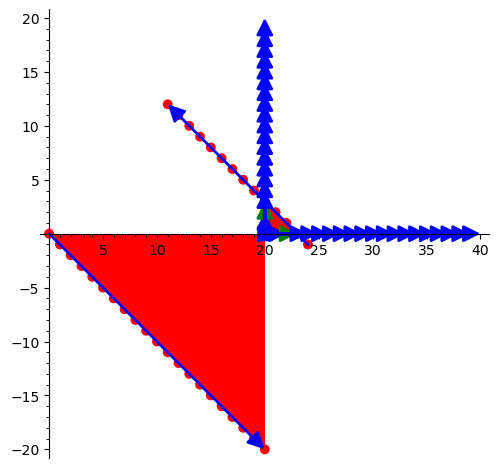

In [33]:
g = Graphics()
p0 = vector( (0,0) )
p1 = vector( (20, -20) )

v_i = p1 - p0
edge_len = gcd(v_i)
v_i_prim = v_i / edge_len

q0 = vector( (24,-1) )
q1 = vector( (11,12) )

g += point(p0)
g += point(p1)
g += arrow( p0, p1 )
L = LineSegment(p0, p1)
for pt in L.integral_points():
    g += point( pt, color="red", size=50)
g += point(q0)
g += point(q1)
g += arrow(q0, q1)
L = LineSegment(q0, q1)
for pt in L.integral_points():
    g += point( pt, color="red", size=50)
    
surg_size = 20
si = surg_size*vector( (1,0) )




L = LineSegment( q0, q1 )
edge_points = OrderedSet( L.integral_points() )
v_prim1 = vector( (1,0) )
v_prim2 = vector( (0,1) )

num_start_points = edge_len - surg_size + 1

intersection_found = False

for m in [0,..,num_start_points]:
    if intersection_found: 
        g += polygon( [base_l, apex, base_r ], color="red" )
        g += polygon( [base_l2, apex, base_r2 ], color="red" )
        print(f"{base_l2} and {base_r2}.")
        break
    base_l = vector(ZZ, p0 + m*v_i_prim )
    apex = vector(ZZ, base_l + si )
    base_r = vector(ZZ, base_l + surg_size*v_i_prim )
    g += point(apex, color="red", size=50)
    for t in [0,1,..,20]:
        vn_l = vector( apex + t*v_prim1 )
        vn_r = vector( apex + t*v_prim2 )
        vn_l.set_immutable()
        vn_r.set_immutable()
        if vn_l in edge_points and vn_r in edge_points:
            intersection_found = True
            g += arrow( apex, vn_l, color="green")
            g += point( vn_l, color="green", size=50)
            g += arrow( apex, vn_r, color="green")
            g += point( vn_r, color="green", size=50)
            base_l2 = vn_l
            base_r2 = vn_r
            continue
        else:
            g += arrow( apex, vn_l)
            g += arrow( apex, vn_r)

if not intersection_found:
    print("Bad surgery")
g

\(l_{0}\),\(l_{1}\),\(l_{2}\),\(l_{3}\),\(l_{4}\),\(l_{5}\),\(l_{6}\),\(l_{7}\),\(l_{8}\),\(l_{9}\),\(l_{10}\),\(l_{11}\),\(l_{12}\),\(l_{13}\),\(l_{14}\),\(l_{15}\),\(l_{16}\),\(l_{17}\),\(l_{18}\),\(l_{19}\)
\(1\),\(2\),\(1\),\(2\),\(1\),\(0\),\(1\),\(2\),\(1\),\(2\),\(1\),\(2\),\(1\),\(0\),\(1\),\(2\),\(6\),\(6\),\(6\),\(6\)


Aut(P) = C2, order 2 with 1 generators:


[-1  0]
[ 0 -1]

\(a_{0}\),\(a_{1}\),\(a_{2}\),\(a_{3}\),\(a_{4}\),\(a_{5}\),\(a_{6}\),\(a_{7}\),\(a_{8}\),\(a_{9}\)
\(1\),\(1\),\(1\),\(1\),\(1\),\(0\),\(1\),\(1\),\(3\),\(3\)


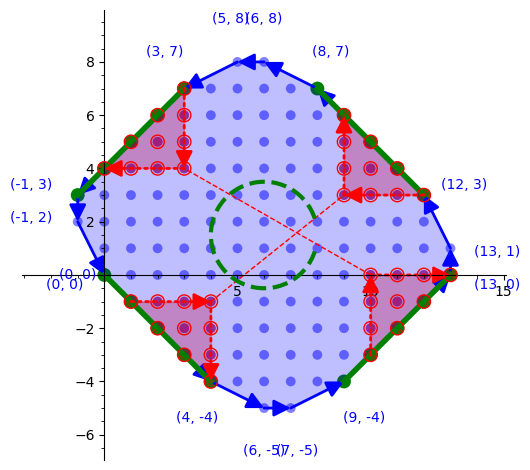

In [34]:
s1 = Sterk1()

# a = (1, 1, 0, 0, 0, 1, 1, 0, 2, 2)

s1.plot_random_IAS(max_a = 1, surg_inflate = 3)

\(l_{1}\),\(l_{2}\),\(l_{3}\),\(l_{4}\),\(l_{5}\),\(l_{6}\),\(l_{7}\),\(l_{8}\),\(l_{9}\),\(l_{10}\),\(l_{11}\),\(l_{12}\),\(l_{13}\),\(l_{14}\),\(l_{15}\),\(l_{16}\),\(l_{17}\),\(l_{18}\),\(l_{19}\)
\(4\),\(1\),\(2\),\(1\),\(2\),\(1\),\(2\),\(1\),\(2\),\(0\),\(2\),\(1\),\(2\),\(1\),\(2\),\(1\),\(2\),\(1\),\(4\)


Aut(P) = C2, order 2 with 1 generators:


[-1  0]
[ 0  1]

\(a_{0}\),\(a_{1}\),\(a_{2}\),\(a_{3}\),\(a_{4}\),\(a_{5}\),\(a_{6}\),\(a_{7}\),\(a_{8}\),\(a_{9}\)
\(2\),\(1\),\(1\),\(1\),\(1\),\(1\),\(1\),\(1\),\(1\),\(0\)


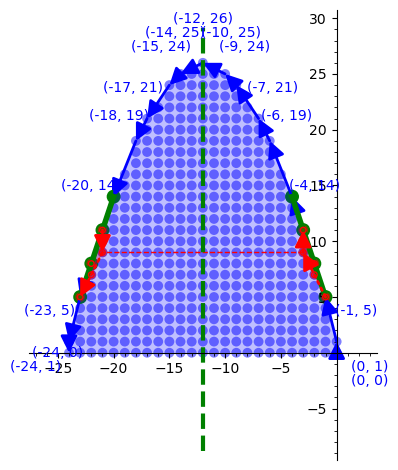

In [35]:
s2 = Sterk2()
s2.plot_random_IAS( max_a = 1, surg_inflate = 2)

\(l_{0}\),\(l_{1}\),\(l_{2}\),\(l_{3}\),\(l_{4}\),\(l_{5}\),\(l_{6}\),\(l_{7}\),\(l_{8}\),\(l_{9}\),\(l_{10}\),\(l_{11}\),\(l_{12}\),\(l_{13}\),\(l_{14}\),\(l_{15}\),\(l_{16}\),\(l_{17}\),\(l_{18}\),\(l_{19}\)
\(2\),\(2\),\(2\),\(2\),\(2\),\(2\),\(2\),\(4\),\(2\),\(4\),\(2\),\(2\),\(2\),\(2\),\(2\),\(2\),\(24\),\(6\),\(30\),\(6\)


Aut(P) = C2, order 2 with 1 generators:


[0 1]
[1 0]

(23, 0) and (12, 11).


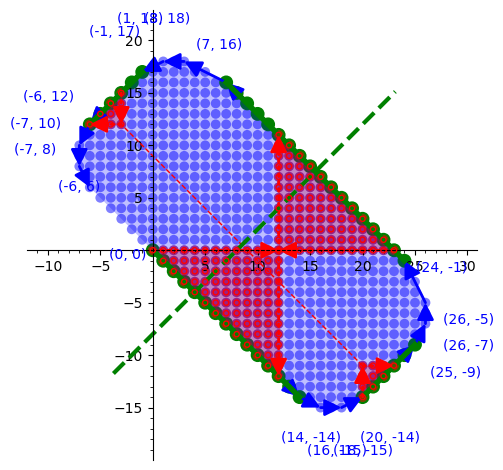

In [36]:
s3 = Sterk3()

l0 = 2
l1 = 2
l2 = 2
l3 = 2
l4 = 2
l5 = 2
l6 = 2
l7 = 4
l8 = l0
l9 = l7
l10 = l6
l11 = l5
l12 = l4
l13 = l3
l14 = l2
l15 = l1
l16 = 24
l17 = 6
l18 = 30
l19 = l17

s3.plot_IAS_ell([
    l0,l1,l2,l3,l4,
    l5,l6,l7,l8,l9,
    l10,l11,l12,l13,l14,
    l15,l16,l17,l18,l19
])

In [62]:
# S = L_20_2_0.submodule_with_basis([
#     v1, v2, v3, v4, v5, v6, v7, v8, 
#     v9, v10, v11, v12, v13, v14, v15, v16, 
#     v17, v18
# ]).base_extend(QQ)

# assert S.rank() == 18 and S.degree() == 20

# w1,...,w18 = S.gens()
# W = list(S.gens())

# assert len(W) == 18

# for wi in W:
#     wi.set_immutable()

# w19 = sum([ W[i] * r1[i+2] for i in range(18) ])
# w20 = sum([ W[i] * r2[i+2] for i in range(18) ])
# w21 = sum([ W[i] * r3[i+2] for i in range(18) ])
# w22 = sum([ W[i] * r4[i+2] for i in range(18) ])

# F = S.hom([ 
#     S(v9), S(v10), S(v11), S(v12), S(v13), S(v14), S(v15), S(v16), 
#     S(v1), S(v2), S(v3), S(v4), S(v5), S(v6), S(v7), S(v8), 
#     S(v19), S(v20)
# ])

# assert F.is_bijective()
# assert F.is_endomorphism()
# #assert (F^2).is_identity()

# print(F^2)

# #F
# Es = F.eigenspaces()
# Es1 = [e for e in Es if e[0] == 1][0][1]
# #Es1

In [57]:
S.degree()

20

In [42]:
Roots.<r0,...,r21> = VectorSpace(QQ, 22)
A13.<a0,...,a13> = PolynomialRing(QQ, 14)
Ell.<l0,...,l21> = PolynomialRing(QQ, 22)

R = list( Roots.gens() )
A = list( A13.gens() )
L = list( Ell.gens() )


In [43]:
# Project up Sterk 1

F = Roots.hom([
    r8, r9, r10, r11, 
    r12, r13, r14, r15, 
    r0,r1, r2, r3, 
    r4, r5, r6, r7,
    r18, r19, r16, r17,
    r20, r21
])
Es1 = [e[1] for e in F.eigenspaces() if e[0] == 1][0]

print(Es1)

known_eigenspace_rank_Sterk1 = 12

assert Es1.basis_matrix().rank() == known_eigenspace_rank_Sterk1

all_As = []
for i in range(known_eigenspace_rank_Sterk1):
    bi = sum([ W[j] * (Es1.basis_matrix().T).column(i)[j] for j in range(22) ])
    all_As.append(bi)

all_As = matrix(all_As).T
print( all_As.dimensions(), all_As.rank() )

assert all_As.rank() == 10

a10 = all_As.column(10)
a11 = all_As.column(11)

ten_As = matrix(QQ, all_As.columns()[0:10]).T

assert ten_As.rank() == 10

rel_1 = ten_As.solve_right(a10)
rel_2 = ten_As.solve_right(a11)

assert a10 == sum([ rel_1[i] * ten_As.column(i) for i in range(10) ])
assert a11 == sum([ rel_2[i] * ten_As.column(i) for i in range(10) ])

show( matrix( [rel_1, rel_2] ) )

to_basis_Sterk1 = Es1.basis_matrix().T

A10_to_A12 = identity_matrix(QQ, 10, 10).stack( 
    matrix( [ list(rel_1) , list(rel_2) ] ) )

parity_fix_A10 = identity_matrix(QQ, 10)
for i in [1,3,5,7]:
    parity_fix_A10[i,i] = 2
    
A10_to_A12 * parity_fix_A10 * vector( A[0:10] )

#M2 * vector(A[0:10])

def project_up_Sterk1(a):
    #a = list(a)
    # assert len(a) == 10, "Need a 10-dim vector."
    # a.append( sum([ rel_1[i] * a[i] for i in range(10) ]) )
    # a.append( sum([ rel_2[i] * a[i] for i in range(10) ]) )
    # assert len(a) == known_eigenspace_rank_Sterk1
    a = vector(a)
    l20 = to_basis_Sterk1 * A10_to_A12 * parity_fix_A10 * a
    show(table([
        list( A[0:10] ),
        list( a ),
        list( parity_fix_A10 * vector( A[0:10] ) ),
        list( parity_fix_A10 * a),
        list( A[0:known_eigenspace_rank_Sterk1] ),
        list( A10_to_A12 * parity_fix_A10 * a )
    ]))
    show(table(columns=[
        list(L),
        list(to_basis_Sterk1 * vector( A[0:known_eigenspace_rank_Sterk1] ) ),
        list( l20 )
    ]))
    return l20

ell = project_up_Sterk1([ 0,0,1,0,0, 0,0,0,0,0 ])
for i in [0,..,7]:
    assert ell[i] == ell[8+i]
assert ell[16] == ell[18]
assert ell[17] == ell[19]

rs = []
for r in Es1.basis_matrix().rows():
    rl = lmap(lambda asd: "." if asd == 0 else str(asd), r)
    rs.append(rl)

show( table( 
    ([list( Es1.basis_matrix().T * vector( A[0:12] ) )] +
    rs) 
))

Vector space of degree 22 and dimension 12 over Rational Field
Basis matrix:
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
(20, 12) 11


AssertionError: 

In [44]:
# Project up Sterk 3

F3 = Roots.hom([
    r0, 
    r15, r14, r13, r12, r11, r10, r9, 
    r8,
    r7, r6, r5, r4, r3, r2, r1, # End boundary
    r16, r19, r18, r17,
    r20, r21
])

assert (F3^2).is_identity()

F3_2 = Roots.hom([
    r0, r1, r2, r3, r4, r5, r6, r7, 
    r8, r9, r10, r11, r12, r13, r14, r15,
    r16 + r20, r17,
    r18 + r20, r19,
    -r20, 2*r20 + r21
    
])
F3_2
G3 = F3_2 * F3

assert G3.is_endomorphism()

Es3 = [e[1] for e in G3.eigenspaces() if e[0] == 1][0]
Es3
show( Es3.basis_matrix() )

r20_perp = Roots.subspace( [r20] ).complement()

subspace_sterk3 = Es3.intersection( r20_perp )

assert subspace_sterk3.dimension() == 12

to_sterk3_subspace = subspace_sterk3.basis_matrix().T


#########

known_eigenspace_rank_Sterk3 = 12

all_As = []
for i in range(known_eigenspace_rank_Sterk3):
    bi = sum([ W[j] * to_sterk3_subspace.column(i)[j] for j in range(22) ])
    all_As.append(bi)

all_As = matrix(all_As).T
print( all_As.dimensions(), all_As.rank() )

assert all_As.rank() == 10

a11 = all_As.column(10)
a12 = all_As.column(11)

ten_As = matrix(QQ, all_As.columns()[0:10]).T

rel_1 = ten_As.solve_right(a11)
rel_2 = ten_As.solve_right(a12)

assert a11 == sum([ rel_1[i] * ten_As.column(i) for i in range(10) ])
assert a12 == sum([ rel_2[i] * ten_As.column(i) for i in range(10) ])

show( matrix( [rel_1, rel_2] ) )

A10_to_A13 = identity_matrix(QQ, 10, 10).stack( 
    matrix( [ list(rel_1) , list(rel_2)] ) )

parity_fix_A10 = identity_matrix(QQ, 10)
for i in [1, 3, 5, 7]:
    parity_fix_A10[i,i] = 4

for i in [2, 6]:
    parity_fix_A10[i,i] = 2

def project_up_Sterk3(a):
    a = vector(a)
    ap = A10_to_A13 * parity_fix_A10 * a
    ap[11] = abs( ap[11] )
    l20 = to_sterk3_subspace * ap
    l20[20] = 0
    show(table([
        list( A[0:10] ),
        list( a ),
        list( parity_fix_A10 * vector( A[0:10] ) ),
        list( parity_fix_A10 * a),
        list( A[0:known_eigenspace_rank_Sterk3] ),
        list( A10_to_A13 * parity_fix_A10 * a )
    ]))
    show(table(columns=[
        list(L),
        list(to_sterk3_subspace * vector( A[0:known_eigenspace_rank_Sterk3] ) ),
        list( l20 )
    ]))
    return l20

ell = project_up_Sterk3([ 1,1,1,1,1, 1,1,1,1,1 ])

for i in [1,..,7]:
    assert ell[i] == ell[16-i]
assert ell[17] == ell[19]
assert ell[20] == 0
for l in ell:
    assert l >= 0


[   1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
[   0    1    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0    0    0    0    0]
[   0    0    1    0    0    0    0    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0]
[   0    0    0    1    0    0    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0    0]
[   0    0    0    0    1    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0    0    0]
[   0    0    0    0    0    1    0    0    0    0    0    1    0    0    0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    1    0    0    0    1    0    0    0    0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    1    0    1    0    0    0    0    0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0    0    0 -1/2]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    1    0    0]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0 -1/2]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    1    1]

(20, 12) 11


AssertionError: 

In [45]:
# Project up Sterk4

F4 = Roots.hom([
    r12, r11, r10, r9, r8,
    r7, r6, r5,
    r4, r3, r2, r1, r0,
    r15, r14, r13,
    r19, r18, r17, r16,
    r21, r20
])
Es4 = [e[1] for e in F4.eigenspaces() if e[0] == 1][0]

known_eigenspace_rank_Sterk4 = 12

all_As = []
for i in range(known_eigenspace_rank_Sterk4):
    bi = sum([ W[j] * (Es4.basis_matrix().T).column(i)[j] for j in range(22) ])
    all_As.append(bi)

all_As = matrix(all_As).T
print( all_As.dimensions(), all_As.rank() )

assert all_As.rank() == 10

a10 = all_As.column(10)
a11 = all_As.column(11)

ten_As = matrix(QQ, all_As.columns()[0:10]).T

rel_1 = ten_As.solve_right(a10)
rel_2 = ten_As.solve_right(a11)

assert a10 == sum([ rel_1[i] * ten_As.column(i) for i in range(10) ])
assert a11 == sum([ rel_2[i] * ten_As.column(i) for i in range(10) ])

show( matrix( [rel_1, rel_2] ) )

to_basis_Sterk4 = Es4.basis_matrix().T

A10_to_A12 = identity_matrix(QQ, 10, 10).stack( 
    matrix( [ list(rel_1) , list(rel_2) ] ) )

parity_fix_A10 = identity_matrix(QQ, 10)
for i in [1,3,5,7,9]:
    parity_fix_A10[i,i] = 2
    
A10_to_A12 * parity_fix_A10 * vector( A[0:10] )

def project_up_Sterk4(a, tables=True):
    a = vector(a)
    ap = A10_to_A12 * parity_fix_A10 * a
    #ap[11] = abs( ap[11] )
    l20 = to_basis_Sterk4 * ap
    #l20[20] = 0
    if tables:
        show(table([
            list( A[0:10] ),
            list( a ),
            list( parity_fix_A10 * vector( A[0:10] ) ),
            list( parity_fix_A10 * a),
            list( A[0:known_eigenspace_rank_Sterk4] ),
            list( A10_to_A12 * parity_fix_A10 * a )
        ]))
        show(table(columns=[
            list(L),
            list(to_basis_Sterk4 * vector( A[0:known_eigenspace_rank_Sterk4] ) ),
            list( l20 )
        ]))
    return l20

ell = project_up_Sterk4([ 1,1,1,1,1, 1,1,1,1,1 ])
for i in range(14):
    assert ell[(14+i) % 16] == ell[(14-i) % 16]
assert ell[15] == ell[13]
assert ell[16] == ell[19]
assert ell[17] == ell[18]

(20, 12) 11


AssertionError: 

In [46]:
# Project up Sterk 5

ref_vectors = [w1, w3, w5, w7, w9, w11, w13, w15]
ref_vectors_rs = [r1, r3, r5, r7, r9, r11, r13, r15]

Refs_S5 = [ 
    L_20_2_0.get_reflection_matrix( wi )
    for wi in ref_vectors
]


RefComp = reduce(lambda a,b: a*b, Refs_S5)

WM = matrix(W).T

M_S5_hom = []
for i in range(22):
    if i <= 15:
        x = WM.solve_right( RefComp * W[i] )
    if i >= 16:
        WM_subset = WM.columns()[15:]
        WS = matrix(QQ, WM_subset).T
        xp = WS.solve_right( RefComp * W[i] )
        x = [0]*22
        for i, val in enumerate(xp):
            x[15 + i] = val
    M_S5_hom.append(x)

images = []
for v in M_S5_hom:
    vri = sum([ R[i] * v[i] for i in range(len(v)) ])
    images.append(vri)
    
#M_S5_hom = matrix(M_S5_hom).T
#show( M_S5_hom )

F2_S5 = Roots.hom(
    images
)

assert F2_S5.is_bijective()
assert F2_S5.is_endomorphism()
assert (F2_S5^2).is_identity()

Es5 = [e[1] for e in F2_S5.eigenspaces() if e[0] == 1][0]
print( Es5 )

####################
known_eigenspace_rank_Sterk5 = 14

all_As = []
for i in range(known_eigenspace_rank_Sterk5):
    bi = sum([ W[j] * (Es5.basis_matrix().T).column(i)[j] for j in range(22) ])
    all_As.append(bi)

all_As = matrix(all_As).T
print( all_As.dimensions(), all_As.rank() )

assert all_As.rank() == 10

a10 = all_As.column(10)
a11 = all_As.column(11)
a12 = all_As.column(12)
a13 = all_As.column(13)


ten_As = matrix(QQ, all_As.columns()[0:10]).T

rel_1 = ten_As.solve_right(a10)
rel_2 = ten_As.solve_right(a11)
rel_3 = ten_As.solve_right(a12)
rel_4 = ten_As.solve_right(a13)


assert a10 == sum([ rel_1[i] * ten_As.column(i) for i in range(10) ])
assert a11 == sum([ rel_2[i] * ten_As.column(i) for i in range(10) ])
assert a12 == sum([ rel_3[i] * ten_As.column(i) for i in range(10) ])
assert a13 == sum([ rel_4[i] * ten_As.column(i) for i in range(10) ])


show( matrix( [rel_1, rel_2, rel_3, rel_4] ) )

def project_up_Sterk5(a):
    at = copy(a)
    a = list(a)
    assert len(a) == 10, "Need a 10-dim vector."
    a.append( sum([ rel_1[i] * a[i] for i in range(10) ]) )
    a.append( sum([ rel_2[i] * a[i] for i in range(10) ]) )
    a.append( sum([ rel_3[i] * a[i] for i in range(10) ]) )
    a.append( sum([ rel_4[i] * a[i] for i in range(10) ]) )
    #a.append(0)
    assert len(a) == known_eigenspace_rank_Sterk5
    a = vector(a)
    l20 = Es5.basis_matrix().T * a
    l20[1] = 0
    l20[3] = 0
    l20[5] = 0
    l20[7] = 0
    l20[9] = 0
    l20[11] = 0
    l20[13] = 0
    l20[15] = 0
    show(table([
        list( A[0:10] ),
        list( at ),
        list( A[0:known_eigenspace_rank_Sterk5] ),
        list( a )
    ]))
    show(table(columns=[
        list(L),
        list(matrix( Es5.basis() ).T * vector( A[0:known_eigenspace_rank_Sterk5] ) ),
        list( l20 )
    ]))
    return l20

ell = project_up_Sterk5([ 1,2,3,4,5,6,7,8,9,10 ])
# for i in range(14):
#     assert ell[(14+i) % 16] == ell[(14-i) % 16]
# assert ell[15] == ell[13]
# assert ell[16] == ell[19]
# assert ell[17] == ell[18]



AssertionError: 

In [ ]:
# Sterk 5 checks

gr = L_20_2_0.gram_matrix()

all_refs = [ L_20_2_0.get_reflection_matrix( wi ) for wi in ref_vectors ]

assert all_refs[0] * w1 == -w1
assert all_refs[1] * w3 == -w3
assert all_refs[2] * w5 == -w5
assert all_refs[3] * w7 == -w7
assert all_refs[4] * w9 == -w9

M = matrix()
all_refs_w_basis = []
for ref_i in all_refs:
    ref_i_in_w_basis = []
    for wj in W:
        bij = matrix(W).solve_left( ref_i * wj )
        ref_i_in_w_basis.append(bij)
    all_refs_w_basis.append( matrix(ref_i_in_w_basis).T )

#show( all_refs_w_basis )

print( all_refs[0].dimensions() )
print( len( W[0] ) )
print( all_refs_w_basis[0].dimensions() )
print( len( r1 ) )
assert all_refs_w_basis[0] * r1 == -r1
assert all_refs_w_basis[1] * r3 == -r3
assert all_refs_w_basis[2] * r5 == -r5
assert all_refs_w_basis[3] * r7 == -r7
assert all_refs_w_basis[4] * r9 == -r9

Lp = L_20_2_0.base_extend(QQ)
Fs = [ Lp.hom( [ Lp(Rj * ei) for ei in Lp.basis() ] ) for Rj in all_refs ]
for F in Fs:
    assert F.is_bijective()
    assert F.is_endomorphism()
    assert (F^2).is_identity()

F = product(Fs)
assert F.is_bijective()
assert F.is_endomorphism()
assert (F^2).is_identity()

esp = F.eigenspaces()[1][1]

print( esp )
show( esp.basis_matrix().T.dimensions() )
show( esp.basis_matrix().T.rank() )
#show( esp.basis_matrix().T )

esp.basis_matrix() * Lp.basis_matrix()

#ref_vectors

# Sterk 3 Experiments

<img src="18_2_0_display.png" alt="Drawing" style="width: 45%;"/><img src="Sterk3.png" alt="Drawing" style="width: 45%;"/>


In [99]:
WSterk = [w0,w1,w2,w3,
     w4,w5,w6,w7,
     w8,w9,w10,w11,
     w12,w13,w14,w15,
     w16,w17,w18,w19,
     w20,w21
    ]

for w in WSterk:
    w.set_immutable()

assert len(list(set( W ))) == 22

show(matrix(WSterk))

22 x 20 dense matrix over Rational Field (use the '.str()' method to see the entries)

In [100]:
VertFlipMap = {
    WSterk[0]: WSterk[12],
    WSterk[1]: WSterk[11],
    WSterk[2]: WSterk[10],
    WSterk[3]: WSterk[9],
    WSterk[4]: WSterk[8],
    WSterk[5]: WSterk[7],
    WSterk[6]: WSterk[6],
    WSterk[7]: WSterk[5],
    WSterk[8]: WSterk[4],
    WSterk[9]: WSterk[3],
    WSterk[10]: WSterk[2],
    WSterk[11]: WSterk[1],
    WSterk[12]: WSterk[0],
    WSterk[13]: WSterk[15],
    WSterk[14]: WSterk[14],
    WSterk[15]: WSterk[13],
    WSterk[16]: WSterk[19],
    WSterk[17]: WSterk[18],
    WSterk[18]: WSterk[17],
    WSterk[19]: WSterk[16],
    WSterk[20]: WSterk[21],
    WSterk[21]: WSterk[20]
}


source_root_matrix = matrix( list(VertFlipMap.keys() ) )
target_root_matrix = matrix( list( VertFlipMap.values() ) )

P = zero_matrix(QQ, 22)
for i, w in enumerate(WSterk):
    j = WSterk.index(VertFlipMap[w])
    P[i,j] = 1

show(P)

# F = (P * source_root_matrix) * source_root_matrix.pseudoinverse()  

# invariant_root_space = (F - identity_matrix(QQ, 22)).right_kernel()
# print( invariant_root_space )

22 x 22 dense matrix over Rational Field (use the '.str()' method to see the entries)

In [210]:
class ZeroIndexedPermutation:
    """0-indexed wrapper for Sage permutations using cycle notation."""
    
    def __init__(self, cycles, symmetric_group_size):
        """Initialize from 0-indexed cycles and SymmetricGroup."""
        symmetric_group = SymmetricGroup( symmetric_group_size )
        self._size = symmetric_group.degree()
        
        # Convert 0-indexed cycles to 1-indexed for Sage
        one_indexed_cycles = [tuple(x + 1 for x in cycle) for cycle in cycles]
        
        if one_indexed_cycles:
            self._sage_perm = symmetric_group(one_indexed_cycles)
        else:
            self._sage_perm = symmetric_group.identity()
    
    def __call__(self, i):
        """Evaluate at 0-indexed position i."""
        return self._sage_perm(i + 1) - 1
    
    def domain(self):
        """Return 0-indexed domain."""
        return range(self._size)
    
    def representation(self, L):
        """Map list L by permutation: L_i -> L_{perm(i)}."""
        if len(L) != self._size:
            raise ValueError(f"List length {len(L)} must match permutation size {self._size}")
        
        return {L[i]: L[self(i)] for i in range(len(L))}

    def matrix(self):
        """Return the permutation matrix representing this permutation.
        
        Uses Sage's built-in matrix method for permutations.
        """
        return self._sage_perm.matrix()
    
    def __repr__(self):
        """String representation."""
        zero_list = [self(i) for i in range(self._size)]
        return f"ZeroIndexedPermutation({zero_list})"
    
    @property
    def sage_permutation(self):
        """Access underlying Sage permutation."""
        return self._sage_perm


def test_zero_indexed_permutation():
    """Test ZeroIndexedPermutation with cycle notation."""
    from sage.groups.perm_gps.permgroup_named import SymmetricGroup
    
    test_cases = [
        {
            'cycles': [], 
            'group_size': 4, 
            'evaluations': [(0, 0), (1, 1), (2, 2), (3, 3)]
        },
        {
            'cycles': [(0, 1)], 
            'group_size': 4, 
            'evaluations': [(0, 1), (1, 0), (2, 2), (3, 3)]
        },
        {
            'cycles': [(0, 12), (1, 11)], 
            'group_size': 22, 
            'evaluations': [(0, 12), (1, 11), (2, 2), (11, 1), (12, 0), (13, 13)]
        },
        {
            'cycles': [(0, 1, 2)], 
            'group_size': 5, 
            'evaluations': [(0, 1), (1, 2), (2, 0), (3, 3), (4, 4)]
        },
        {
            'cycles': [(0, 3), (1, 2)], 
            'group_size': 4, 
            'evaluations': [(0, 3), (1, 2), (2, 1), (3, 0)]
        }
    ]
    
    for case in test_cases:
        perm = ZeroIndexedPermutation(case['cycles'], case['group_size'])
        for i, expected in case['evaluations']:
            assert perm(i) == expected
        assert list(perm.domain()) == list(range(case['group_size']))


def test_representation():
    """Test representation method."""
    from sage.groups.perm_gps.permgroup_named import SymmetricGroup
    
    test_cases = [
        {
            'cycles': [], 
            'group_size': 3, 
            'list': ['a', 'b', 'c'], 
            'expected': {'a': 'a', 'b': 'b', 'c': 'c'}
        },
        {
            'cycles': [(0, 1)], 
            'group_size': 3, 
            'list': ['x', 'y', 'z'], 
            'expected': {'x': 'y', 'y': 'x', 'z': 'z'}
        },
        {
            'cycles': [(0, 1, 2)], 
            'group_size': 4, 
            'list': ['a', 'b', 'c', 'd'], 
            'expected': {'a': 'b', 'b': 'c', 'c': 'a', 'd': 'd'}
        },
        {
            'cycles': [(0, 2)], 
            'group_size': 3, 
            'list': [10, 20, 30], 
            'expected': {10: 30, 20: 20, 30: 10}
        },
        {
            'cycles': [(0, 1)], 
            'group_size': 2, 
            'list': ['first', 'second'], 
            'expected': {'first': 'second', 'second': 'first'}
        }
    ]
    
    for case in test_cases:
        perm = ZeroIndexedPermutation(case['cycles'], case['group_size'])
        result = perm.representation(case['list'])
        assert result == case['expected']


test_cases = [
        {
            'cycles': [], 
            'group_size': 3,
            'sage_cycles': []
        },
        {
            'cycles': [(0, 1)], 
            'group_size': 3,
            'sage_cycles': [(1, 2)]
        },
        {
            'cycles': [(0, 1, 2)], 
            'group_size': 3,
            'sage_cycles': [(1, 2, 3)]
        },
        {
            'cycles': [(0, 1), (2, 3)], 
            'group_size': 4,
            'sage_cycles': [(1, 2), (3, 4)]
        },
        {
            'cycles': [(0, 1, 2, 3, 4)], 
            'group_size': 5,
            'sage_cycles': [(1, 2, 3, 4, 5)]
        }
    ]
    
for case in test_cases:
    perm = ZeroIndexedPermutation(case['cycles'], case['group_size'])
    
    if case['sage_cycles']:
        expected = SymmetricGroup(case['group_size'])(case['sage_cycles']).matrix()
    else:
        expected = SymmetricGroup(case['group_size']).identity().matrix()
        
    assert perm.matrix() == expected


# Run tests
test_zero_indexed_permutation()
test_representation()
test_matrix()

my_cycles = [(0, 12), (1, 11)]
perm = ZeroIndexedPermutation(my_cycles, 22)

assert perm(0) == 12
assert perm(1) == 11
assert perm(2) == 2
assert perm(11) == 1
assert perm(12) == 0
assert perm(13) == 13

# Test the representation method
test_list = list(range(22))
result = perm.representation(test_list)
for i in range(22):
    assert result[i] == perm(i)

P_result = perm.matrix()
E_result = VectorSpace(QQ, 22).basis()

assert P_result * E_result[0] == E_result[12]
assert P_result * E_result[1] == E_result[11]
assert P_result * E_result[2] == E_result[2]
assert P_result * E_result[11] == E_result[1]
assert P_result * E_result[12] == E_result[0]
assert P_result * E_result[13] == E_result[13]

In [236]:
def print_matrix(matrix, zero_char="·"):
    dense = matrix.dense_matrix() if hasattr(matrix, 'dense_matrix') else matrix
    rows, cols = dense.nrows(), dense.ncols()
    
    print(f"({rows},{cols}) over {dense.base_ring()}")
    
    # Convert to strings and find max width
    entries = [[str(dense[i,j]) if dense[i,j] != 0 else zero_char for j in range(cols)] for i in range(rows)]
    
    # Include column headers in width calculation
    max_width = max(
        max(len(entry) for row in entries for entry in row),  # Matrix entries
        max(len(str(j)) for j in range(cols))  # Column headers
    )
    
    # Column header
    row_index_width = len(str(rows - 1))
    header = " " * (row_index_width + 2) + "".join(f"{j:>{max_width}}" + (" " if j < cols - 1 else "") for j in range(cols))
    print(header)
    
    # Separator line (match header length exactly)
    separator = " " * (row_index_width + 2) + "-" * len(header[row_index_width + 2:])
    print(separator)
    
    # Matrix rows
    for i in range(rows):
        row_str = f"{i:>{row_index_width}}: " + "".join(f"{entries[i][j]:>{max_width}}" + (" " if j < cols - 1 else "") for j in range(cols))
        print(row_str)

In [235]:
vert_flip_perm = ZeroIndexedPermutation([
    (0, 12), 
    (1, 11), 
    (2, 10), 
    (3, 9), 
    (4, 8), 
    (5, 7), 
    (13, 15), 
    (16, 19), 
    (17, 18), 
    (20, 21)
    ], 22
)

#VertFlipMap = vert_flip_perm.representation( WSterk )
P = vert_flip_perm.matrix()
print_matrix(P)

(22,22) over Integer Ring
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
    -----------------------------------------------------------------
 0:  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·
 1:  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
 2:  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
 3:  ·  ·  ·  ·  ·  ·  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
 4:  ·  ·  ·  ·  ·  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
 5:  ·  ·  ·  ·  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
 6:  ·  ·  ·  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
 7:  ·  ·  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
 8:  ·  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
 9:  ·  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
10:  ·  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·
11:  ·  1  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  ·  · 

In [158]:
[ var(f"r{i}") for i in range(30) ]
rs = [ eval(f"r{i}") for i in range(30) ]
r = vector( rs[0:22] )
print(r)

[ var(f"b{i}") for i in range(30) ]
bs = [ eval(f"b{i}") for i in range(30) ]
b = vector( bs[0:10] )
print(b)

# 20x22
R = source_root_matrix.transpose()
assert R.dimensions() == (20,22)
assert all([ wi == W[i] for i, wi in enumerate( R.columns() ) ])

# 22x22
P = zero_matrix(QQ, 22)
for i, w in enumerate(WSterk):
    j = WSterk.index(VertFlipMap[w])
    P[j, i] = 1 
assert P.dimensions() == (22,22)

# (20x22) . (22x22) = (20x22)
A = R * (P - identity_matrix(QQ, 22))
assert A.rank() == 8
assert A.left_nullity() == 12
assert A.right_nullity() == 14
assert A.dimensions() == (20, 22)
assert A.ncols() == 8 + 14
assert A.nrows() == 8 + 12

invariant_root_kernel = A.right_kernel()
assert invariant_root_kernel.dimension() == 14
assert invariant_root_kernel.degree() == 22

for i in range(15):
    assert e( (14 + i) % 16, 22) + e( (14-i) % 16, 22 ) in invariant_root_kernel

# 14x22: V -> V_I
ugly_basis = invariant_root_kernel.basis_matrix()
assert ugly_basis.dimensions() == (14,22)
assert ugly_basis.rank() == 14
assert ugly_basis.left_nullity() == 0
assert ugly_basis.right_nullity() == 8

basis_vectors = lmap(list, ugly_basis.LLL().rows() )
basis_vectors.sort(key = functools.cmp_to_key(sort_basis))
assert len( basis_vectors ) == 14

nice_basis = matrix(QQ, basis_vectors)
assert nice_basis.dimensions() == (14, 22)
assert nice_basis.rank() == 14
assert nice_basis.left_nullity() == 0
assert nice_basis.right_nullity() == 8

def disp_mat(M):
    print( "\n" +  "-".join( [""] * 90 ), 
           f"\n{M}",
           "---", 
           M.dimensions(), 
           "\n" +  "-".join( [""] * 85 ) 
        )

disp_mat(nice_basis)

(r0, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16, r17, r18, r19, r20, r21)
(b0, b1, b2, b3, b4, b5, b6, b7, b8, b9)

----------------------------------------------------------------------------------------- 
[ 1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
[ 0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0]
[ 0  0  0  0  0  0

In [163]:
in_ws_basis = []
for coef_vec in nice_basis:
    bi = sum([ coef_vec[i] * WSterk[i] for i in range(len(coef_vec)) ])
    in_ws_basis.append(bi)
assert len(in_ws_basis) == 14
assert all([ len(wi) == 20 for wi in in_ws_basis ])

in_ws_basis_matrix = matrix( in_ws_basis )
assert in_ws_basis_matrix.dimensions() == (14, 20)
assert in_ws_basis_matrix.rank() == 10
assert in_ws_basis_matrix[0:10,:].rank() == 10
disp_mat(in_ws_basis_matrix)


ws_ker = in_ws_basis_matrix.kernel()
assert ws_ker.dimension() == 4
assert ws_ker.basis_matrix().dimensions() == (4,14)
disp_mat(ws_ker.basis_matrix())

for rel in ws_ker.basis_matrix().rows():
    assert sum([ rel[i] * in_ws_basis[i] for i in range(14)]) == 0



----------------------------------------------------------------------------------------- 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   1]
[  0   0   1   1  -4  -5  -7 -10  -8  -6  -4  -2  -2  -3  -3  -6  -5  -4  -3  -2]
[  0   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   1   1  -2  -3  -3  -6  -5  -4  -3  -2  -4  -5  -7 -10  -8  -6  -4  -2]
[  0   0   0   0   0   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   1   0   1   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   1   0]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0]
[  0   0   1   0   0   0   0   0   0   0   0   0  -2  -2  -4  -6  -5  -4  -3  -2]
[  0   0   1   0  -2  -2  -4  -6  -5  -4  -3  -2   0   0   0   0   0   0   0   0]
[  0  

In [172]:
ias = IAS_18_2_0(None)

LGram = L_20_2_0.gram_matrix()

R = ws_ker.basis_matrix()
R_left  = R[:, 0:10]
R_right = R[:, 10:14]

# Solve for the dependency of b10,...,b13 on b0,...,b9
A = - R_right.inverse() * R_left 

# Stack with identity matrix to get the full 14×10 map
M14_10 = block_matrix(2, 1, [identity_matrix(QQ, 10), A])  # 14×10

a14_basis_in_ws = nice_basis * source_root_matrix
assert a14_basis_in_ws.row(0) == WSterk[0] + WSterk[12]
assert a14_basis_in_ws.row(1) == WSterk[1] + WSterk[11]
assert a14_basis_in_ws.dimensions() == (14, 20)


R = source_root_matrix
G = LGram
B = nice_basis



a = vector( bs[0:10] )        # 10x1
assert len(a) == 10

a_14 = M14_10 * a                  # (14x10).(10x1) = 14x1
assert M14_10.dimensions() == (14, 10)
assert len(a_14) == 14

l22 = a14_basis_in_ws.T * a_14     # (20x14).(14x1) = 20x1
assert len(l22) == 20
assert a14_basis_in_ws.T.dimensions() == (20,14)

l22p = source_root_matrix * LGram * l22    # (22x20).(20x20).(20x1) = 22x1
assert len(l22p) == 22
assert source_root_matrix.dimensions() == (22,20)
assert LGram.dimensions() == (20,20)
assert (source_root_matrix * LGram).dimensions() == (22,20)

#  R(22x20) * G(20x20) * R.T(20x22) *B.T (22x14) * M(14x10) = (22,10), maps Q^10 -> Q^22
A3 = R * G * R.T * B.T * M14_10
A3l = ias.M_18_2_0_Full * A3

assert A3.dimensions() == (22, 10)
assert A3l.dimensions() == (22, 10)

l22p = A3 * a
l22p_lens = A3l * a

assert len(a) == 10
assert len(l22p) == 22
assert len(l22p_lens) == 22

show( table(columns=[ list(L), l22p, l22p_lens]) )

assert len(set(l22p)) == 12
assert len(set(l22p_lens)) == 12



\(l_{0}\),"\(-3 \, b_{0} + \frac{1}{2} \, b_{1} - b_{2} - \frac{3}{2} \, b_{3} - b_{4} - \frac{3}{2} \, b_{5} - b_{6} + \frac{1}{2} \, b_{7} - b_{8} + b_{9}\)","\(-\frac{1}{2} \, b_{0} + \frac{5}{2} \, b_{1} + \frac{3}{2} \, b_{2} + \frac{3}{2} \, b_{3} + 2 \, b_{4} + 2 \, b_{5} + 2 \, b_{6} + \frac{5}{2} \, b_{7} + b_{8} - \frac{1}{2} \, b_{9}\)"
\(l_{1}\),"\(2 \, b_{0} - \frac{3}{2} \, b_{1} + 2 \, b_{2} + \frac{3}{2} \, b_{3} + b_{4} + \frac{3}{2} \, b_{5} + b_{6} + \frac{1}{2} \, b_{7} + b_{8}\)","\(b_{0} - \frac{3}{4} \, b_{1} + b_{2} + \frac{3}{4} \, b_{3} + \frac{1}{2} \, b_{4} + \frac{3}{4} \, b_{5} + \frac{1}{2} \, b_{6} + \frac{1}{4} \, b_{7} + \frac{1}{2} \, b_{8}\)"
\(l_{2}\),"\(b_{1} - 2 \, b_{2} + b_{3}\)","\(b_{1} - 2 \, b_{2} + b_{3}\)"
\(l_{3}\),"\(-b_{0} - \frac{1}{2} \, b_{1} - \frac{7}{2} \, b_{3} - \frac{3}{2} \, b_{5} - b_{6} - \frac{1}{2} \, b_{7} - b_{8}\)","\(-\frac{1}{2} \, b_{0} - \frac{1}{4} \, b_{1} - \frac{7}{4} \, b_{3} - \frac{3}{4} \, b_{5} - \frac{1}{2} \, b_{6} - \frac{1}{4} \, b_{7} - \frac{1}{2} \, b_{8}\)"
\(l_{4}\),"\(3 \, b_{0} + \frac{3}{2} \, b_{1} + b_{2} + \frac{3}{2} \, b_{3} - 3 \, b_{4} + \frac{1}{2} \, b_{5} - b_{6} + \frac{5}{2} \, b_{7} + 3 \, b_{8} + b_{9}\)","\(3 \, b_{0} + \frac{5}{2} \, b_{1} + \frac{7}{2} \, b_{2} + \frac{11}{2} \, b_{3} + \frac{5}{2} \, b_{4} + 6 \, b_{5} + 4 \, b_{6} + \frac{5}{2} \, b_{7} + 3 \, b_{8} - \frac{1}{2} \, b_{9}\)"
\(l_{5}\),"\(-b_{2} - 2 \, b_{3} - b_{4} - 5 \, b_{5} - b_{6} + b_{9}\)","\(-\frac{1}{2} \, b_{2} - b_{3} - \frac{1}{2} \, b_{4} - \frac{5}{2} \, b_{5} - \frac{1}{2} \, b_{6} + \frac{1}{2} \, b_{9}\)"
\(l_{6}\),"\(b_{2} + 2 \, b_{3} + 2 \, b_{4} + 5 \, b_{5} - b_{9}\)","\(b_{2} + 2 \, b_{3} + 2 \, b_{4} + 5 \, b_{5} - b_{9}\)"
\(l_{7}\),"\(-b_{2} - 2 \, b_{3} - b_{4} - 5 \, b_{5} - b_{6} + b_{9}\)","\(-\frac{1}{2} \, b_{2} - b_{3} - \frac{1}{2} \, b_{4} - \frac{5}{2} \, b_{5} - \frac{1}{2} \, b_{6} + \frac{1}{2} \, b_{9}\)"
\(l_{8}\),"\(3 \, b_{0} + \frac{3}{2} \, b_{1} + b_{2} + \frac{3}{2} \, b_{3} - 3 \, b_{4} + \frac{1}{2} \, b_{5} - b_{6} + \frac{5}{2} \, b_{7} + 3 \, b_{8} + b_{9}\)","\(3 \, b_{0} + \frac{5}{2} \, b_{1} + \frac{7}{2} \, b_{2} + \frac{11}{2} \, b_{3} + \frac{5}{2} \, b_{4} + 6 \, b_{5} + 4 \, b_{6} + \frac{5}{2} \, b_{7} + 3 \, b_{8} - \frac{1}{2} \, b_{9}\)"
\(l_{9}\),"\(-b_{0} - \frac{1}{2} \, b_{1} - \frac{7}{2} \, b_{3} - \frac{3}{2} \, b_{5} - b_{6} - \frac{1}{2} \, b_{7} - b_{8}\)","\(-\frac{1}{2} \, b_{0} - \frac{1}{4} \, b_{1} - \frac{7}{4} \, b_{3} - \frac{3}{4} \, b_{5} - \frac{1}{2} \, b_{6} - \frac{1}{4} \, b_{7} - \frac{1}{2} \, b_{8}\)"
\(l_{10}\),"\(b_{1} - 2 \, b_{2} + b_{3}\)","\(b_{1} - 2 \, b_{2} + b_{3}\)"


In [177]:
# Create deduplicated vector
def deduplicate_vector(vector):
    seen = {}
    result = []
    
    for i, expr in enumerate(vector):
        if expr in seen:
            result.append("")  # Replace duplicate with empty string
        else:
            seen[expr] = i
            result.append(expr)
    
    return result

deduplicated = deduplicate_vector(l22p)

show( table(columns=[ 
    list(L), 
    deduplicate_vector(l22p), 
    deduplicate_vector(l22p_lens)
]) )


\(l_{0}\),"\(-3 \, b_{0} + \frac{1}{2} \, b_{1} - b_{2} - \frac{3}{2} \, b_{3} - b_{4} - \frac{3}{2} \, b_{5} - b_{6} + \frac{1}{2} \, b_{7} - b_{8} + b_{9}\)","\(-\frac{1}{2} \, b_{0} + \frac{5}{2} \, b_{1} + \frac{3}{2} \, b_{2} + \frac{3}{2} \, b_{3} + 2 \, b_{4} + 2 \, b_{5} + 2 \, b_{6} + \frac{5}{2} \, b_{7} + b_{8} - \frac{1}{2} \, b_{9}\)"
\(l_{1}\),"\(2 \, b_{0} - \frac{3}{2} \, b_{1} + 2 \, b_{2} + \frac{3}{2} \, b_{3} + b_{4} + \frac{3}{2} \, b_{5} + b_{6} + \frac{1}{2} \, b_{7} + b_{8}\)","\(b_{0} - \frac{3}{4} \, b_{1} + b_{2} + \frac{3}{4} \, b_{3} + \frac{1}{2} \, b_{4} + \frac{3}{4} \, b_{5} + \frac{1}{2} \, b_{6} + \frac{1}{4} \, b_{7} + \frac{1}{2} \, b_{8}\)"
\(l_{2}\),"\(b_{1} - 2 \, b_{2} + b_{3}\)","\(b_{1} - 2 \, b_{2} + b_{3}\)"
\(l_{3}\),"\(-b_{0} - \frac{1}{2} \, b_{1} - \frac{7}{2} \, b_{3} - \frac{3}{2} \, b_{5} - b_{6} - \frac{1}{2} \, b_{7} - b_{8}\)","\(-\frac{1}{2} \, b_{0} - \frac{1}{4} \, b_{1} - \frac{7}{4} \, b_{3} - \frac{3}{4} \, b_{5} - \frac{1}{2} \, b_{6} - \frac{1}{4} \, b_{7} - \frac{1}{2} \, b_{8}\)"
\(l_{4}\),"\(3 \, b_{0} + \frac{3}{2} \, b_{1} + b_{2} + \frac{3}{2} \, b_{3} - 3 \, b_{4} + \frac{1}{2} \, b_{5} - b_{6} + \frac{5}{2} \, b_{7} + 3 \, b_{8} + b_{9}\)","\(3 \, b_{0} + \frac{5}{2} \, b_{1} + \frac{7}{2} \, b_{2} + \frac{11}{2} \, b_{3} + \frac{5}{2} \, b_{4} + 6 \, b_{5} + 4 \, b_{6} + \frac{5}{2} \, b_{7} + 3 \, b_{8} - \frac{1}{2} \, b_{9}\)"
\(l_{5}\),"\(-b_{2} - 2 \, b_{3} - b_{4} - 5 \, b_{5} - b_{6} + b_{9}\)","\(-\frac{1}{2} \, b_{2} - b_{3} - \frac{1}{2} \, b_{4} - \frac{5}{2} \, b_{5} - \frac{1}{2} \, b_{6} + \frac{1}{2} \, b_{9}\)"
\(l_{6}\),"\(b_{2} + 2 \, b_{3} + 2 \, b_{4} + 5 \, b_{5} - b_{9}\)","\(b_{2} + 2 \, b_{3} + 2 \, b_{4} + 5 \, b_{5} - b_{9}\)"
\(l_{7}\),,
\(l_{8}\),,
\(l_{9}\),,
\(l_{10}\),,


In [179]:

uniq_entries = list(set(l22p))
show( table(columns=[ [f"$I_{{{i}}}$" for i in [1,..,len(uniq_entries)] ], uniq_entries ] ))

for i in range(15):
    assert l22p[ (14 + i) % 16 ] == l22p[ (14-i) % 16]
    assert l22p_lens[ (14 + i) % 16 ] == l22p_lens[ (14-i) % 16]
    
assert l22p[16] == l22p[19]
assert l22p[17] == l22p[18]
assert l22p[20] == l22p[21]

assert l22p_lens[16] == l22p_lens[19]
assert l22p_lens[17] == l22p_lens[18]
assert l22p_lens[20] == l22p_lens[21]

ias_hold = IAS_18_2_0(None)

vs = lmap(lambda a: a[0] * a[1], zip( l22p_lens[0:16], ias_hold.direction_vectors.values() ))
assert sum(lmap( lambda v: v[0], vs)) == 0
assert sum(lmap( lambda v: v[1], vs)) == 0 

\(I_{1}\),"\(3 \, b_{0} + \frac{3}{2} \, b_{1} + b_{2} + \frac{3}{2} \, b_{3} - 3 \, b_{4} + \frac{1}{2} \, b_{5} - b_{6} + \frac{5}{2} \, b_{7} + 3 \, b_{8} + b_{9}\)"
\(I_{2}\),"\(-b_{2} - 2 \, b_{3} - b_{4} - 5 \, b_{5} - b_{6} + b_{9}\)"
\(I_{3}\),"\(6 \, b_{0} + 3 \, b_{1} - 3 \, b_{3} - 6 \, b_{4} - 7 \, b_{5} - 6 \, b_{6} + 5 \, b_{7} + 6 \, b_{8} + 6 \, b_{9}\)"
\(I_{4}\),"\(b_{1} - 2 \, b_{2} + b_{3}\)"
\(I_{5}\),"\(b_{2} + 2 \, b_{3} + 2 \, b_{4} + 5 \, b_{5} - b_{9}\)"
\(I_{6}\),"\(-b_{0} - \frac{1}{2} \, b_{1} - \frac{7}{2} \, b_{3} - \frac{3}{2} \, b_{5} - b_{6} - \frac{1}{2} \, b_{7} - b_{8}\)"
\(I_{7}\),"\(3 \, b_{0} + b_{1} + b_{2} + b_{3} - b_{7} + 3 \, b_{8} + b_{9}\)"
\(I_{8}\),"\(2 \, b_{1} + 5 \, b_{2} + 8 \, b_{3} + 11 \, b_{4} + 11 \, b_{5} + 10 \, b_{6} - 3 \, b_{9}\)"
\(I_{9}\),"\(-2 \, b_{0} - b_{1} - b_{2} - b_{3} + b_{7} - 4 \, b_{8} - b_{9}\)"
\(I_{10}\),"\(2 \, b_{0} - \frac{3}{2} \, b_{1} + 2 \, b_{2} + \frac{3}{2} \, b_{3} + b_{4} + \frac{3}{2} \, b_{5} + b_{6} + \frac{1}{2} \, b_{7} + b_{8}\)"
\(I_{11}\),"\(-3 \, b_{0} + \frac{1}{2} \, b_{1} - b_{2} - \frac{3}{2} \, b_{3} - b_{4} - \frac{3}{2} \, b_{5} - b_{6} + \frac{1}{2} \, b_{7} - b_{8} + b_{9}\)"
